In [6]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
#import helper

import matplotlib.pyplot as plt

In [7]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [8]:
from torchvision import datasets, transforms   #torchvision has datasets related to CV
# define a transform to normalize/pre-process the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),])

# Download and divide data into batches
train_data = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True) #converts data into batches


In [9]:
# Losses are provided using criterion varible as a convention. For Classification problem we use 
# Cross Entropy loss which in pytorch takes care of Softmax itself so we need to provide the raw values
# Cross entropy is a combination of Softmax loss and negative log likelihood loss
input_size = 784
hidden_layer_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size,hidden_layer_sizes[0]),nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1]), nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[1],output_size))
criterion = nn.CrossEntropyLoss()
# forward pass 
train_data_iter = iter(trainloader)
images, labels = train_data_iter.next()
images.resize_(images.shape[0],784)
probabs = model.forward(images)

Loss= criterion(probabs,labels)
print(Loss)

tensor(2.3057, grad_fn=<NllLossBackward>)


Exercise: Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for nn.LogSoftmax and F.log_softmax you'll need to set the dim keyword argument appropriately. dim=0 calculates softmax across the rows, so each column sums to 1, while dim=1 calculates across the columns so each row sums to 1. Think about what you want the output to be and choose dim appropriately.

In [18]:
input_size = 784
hidden_layer_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size,hidden_layer_sizes[0]),nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1]), nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[1],output_size),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
# forward pass 
train_data_iter = iter(trainloader)
images, labels = train_data_iter.next()
images.resize_(images.shape[0],784)
probabs = model.forward(images)

Loss= criterion(probabs,labels)
print(Loss)

tensor(2.3021, grad_fn=<NllLossBackward>)


## Autograd and Losses

In [29]:
# Here backward() can be applied only to the scalar outputs
# for a scalar output gradient can be calculated with those variables which had requires_grad= True while their creation 
x = torch.randn(2,2,requires_grad= True)
y = x**3
z = torch.mean(y)

print(y.grad_fn)
z.backward()
print(x.grad)
print(.75* x**2)
print(y.grad)

tensor([[0.5531, 0.3799],
        [0.5773, 1.3026]])
tensor([[0.5531, 0.3799],
        [0.5773, 1.3026]], grad_fn=<MulBackward0>)
None


In [31]:
input_size = 784
hidden_layer_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size,hidden_layer_sizes[0]),nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1]), nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[1],output_size),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
# forward pass 
train_data_iter = iter(trainloader)
images, labels = train_data_iter.next()
images.resize_(images.shape[0],784)
probabs = model.forward(images)

Loss= criterion(probabs,labels)
print(Loss)

print('Before backward pass: \n', model[0].weight.grad)

Loss.backward()

print('After backward pass: \n', model[0].weight.grad)

tensor(2.3037, grad_fn=<NllLossBackward>)
Before backward pass: 
 None
After backward pass: 
 tensor([[-9.2854e-04, -9.2854e-04, -9.2854e-04,  ..., -9.2854e-04,
         -9.2854e-04, -9.2854e-04],
        [ 4.6685e-03,  4.6685e-03,  4.6685e-03,  ...,  4.6685e-03,
          4.6685e-03,  4.6685e-03],
        [-6.4598e-05, -6.4598e-05, -6.4598e-05,  ..., -6.4598e-05,
         -6.4598e-05, -6.4598e-05],
        ...,
        [ 1.9165e-03,  1.9165e-03,  1.9165e-03,  ...,  1.9165e-03,
          1.9165e-03,  1.9165e-03],
        [ 3.4352e-04,  3.4352e-04,  3.4352e-04,  ...,  3.4352e-04,
          3.4352e-04,  3.4352e-04],
        [-3.8625e-04, -3.8625e-04, -3.8625e-04,  ..., -3.8625e-04,
         -3.8625e-04, -3.8625e-04]])


Gradient Package Optim

In [32]:
from torch import optim

optimizer = optim.SGD(model.parameters(),lr=0.01)  #Defining SGD optimizer object

## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss


In [36]:


#Step 0: Define the model 
input_size = 784
hidden_layer_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size,hidden_layer_sizes[0]),nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[0],hidden_layer_sizes[1]), nn.ReLU(),
                     nn.Linear(hidden_layer_sizes[1],output_size),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)  #Defining SGD optimizer object
print('Initial Weights',model[0].weight)

#Step 1: Make a forward pass
data_iter = iter(trainloader)
images, labels = data_iter.next()
images.resize_(images.shape[0],784)

optimizer.zero_grad()  # very important to make the gradients zero before every new batch is processed
logits = model.forward(images)

# Step2: Calculate Loss
Loss = criterion(logits, labels)

print('Weights before update',model[0].weight)
# Step3: Calculate Gradients
Loss.backward()

print('Gradients',model[0].weight.grad)
# Step4: Update Gradients 
optimizer.step()

print('Weights after update',model[0].weight)






Initial Weights Parameter containing:
tensor([[-0.0235,  0.0190, -0.0145,  ...,  0.0086, -0.0213, -0.0144],
        [-0.0163,  0.0047,  0.0180,  ...,  0.0116,  0.0338,  0.0325],
        [ 0.0241, -0.0041, -0.0321,  ...,  0.0346,  0.0124,  0.0264],
        ...,
        [-0.0154, -0.0104,  0.0238,  ..., -0.0261,  0.0238,  0.0152],
        [-0.0106,  0.0081, -0.0044,  ..., -0.0165,  0.0086, -0.0099],
        [ 0.0156,  0.0314, -0.0050,  ..., -0.0012, -0.0312,  0.0052]],
       requires_grad=True)
Weights before update Parameter containing:
tensor([[-0.0235,  0.0190, -0.0145,  ...,  0.0086, -0.0213, -0.0144],
        [-0.0163,  0.0047,  0.0180,  ...,  0.0116,  0.0338,  0.0325],
        [ 0.0241, -0.0041, -0.0321,  ...,  0.0346,  0.0124,  0.0264],
        ...,
        [-0.0154, -0.0104,  0.0238,  ..., -0.0261,  0.0238,  0.0152],
        [-0.0106,  0.0081, -0.0044,  ..., -0.0165,  0.0086, -0.0099],
        [ 0.0156,  0.0314, -0.0050,  ..., -0.0012, -0.0312,  0.0052]],
       requires_grad=Tr

Exercise: Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [42]:
# Defining the model 
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

# Loops for epochs
Epoch=15
for i in range(Epoch):
    running_loss=0
    for images,labels in trainloader:
        optimizer.zero_grad()
        images = images.view(images.shape[0],-1)
        scores = model.forward(images)
        
        Loss = criterion(scores,labels)
        
        Loss.backward()
        running_loss += Loss.item()
        optimizer.step()
    print("Avg Training Loss for epoch",i,running_loss/len(trainloader))    

Avg Training Loss for epoch 0 1.9049318448058579
Avg Training Loss for epoch 1 0.8234159511162528
Avg Training Loss for epoch 2 0.5218419579745356
Avg Training Loss for epoch 3 0.4321939013342359
Avg Training Loss for epoch 4 0.3870903822595377
Avg Training Loss for epoch 5 0.358802064490725
Avg Training Loss for epoch 6 0.33895225480580127
Avg Training Loss for epoch 7 0.32355648320493924
Avg Training Loss for epoch 8 0.3110601923851443
Avg Training Loss for epoch 9 0.3000637845062752
Avg Training Loss for epoch 10 0.2904131143951594
Avg Training Loss for epoch 11 0.2816364640858509
Avg Training Loss for epoch 12 0.27332965364413603
Avg Training Loss for epoch 13 0.2657540693982387
Avg Training Loss for epoch 14 0.2586448735464166


tensor(8)


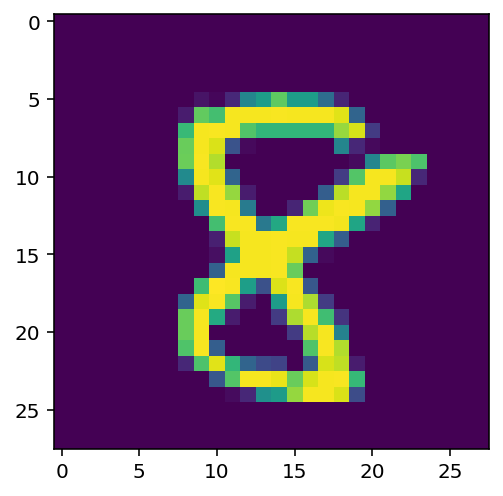

In [53]:
# Checking the predictions
%matplotlib inline
import helper


dataiter = iter(trainloader)
images,labels = next(dataiter)
img = images[55].view(1,784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)  # I used model.forward here
    
# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
#helper.view_classify(img.view(1, 28, 28), ps)
plt.imshow(images[55].reshape(28,28))
print(torch.argmax(ps))